# Booster tune measure 

In this nootebook, I scratched some ideas to measure the betatron tunes of Sirius Booster accelerator using measures of beam position from BPM's.

I consider two aproximations:

1 - The BPM measures the center of the storaged bunch;

2 - The BPM measures directly the betatron oscillations, already discarding the closed orbit displacement.

With the treatment given here, we can only estimate the fractional part of the tunes.

For instance, only the second idea (section 4) gives a good answer to the problem, so you can jump directly to that. 

## Importing all necessary packages

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pyaccel as pa 
import pymodels as pm
import PyNAFF as pnf

%config Completer.use_jedi = False #In my PC, the autocompletion only runs with jedi turned off.

# Creating the model and the bunch

In [22]:
bo = pm.bo.create_accelerator(energy=3e9)
bo.cavity_on = True
bo.radiation_on = True
bo.vchamber_on = True

In [23]:
eq_params = pa.optics.EqParamsFromBeamEnvelope(bo)
emit1, emit2 = eq_params.emit1, np.abs(eq_params.emit2)
bo_et,_ = pa.optics.calc_edwards_teng(bo)
sigmas = eq_params.bunlen
sigmae = eq_params.espread0
bunch = pa.tracking.generate_bunch(emit1=emit1, emit2 = emit2, sigmae=sigmae, 
                                   sigmas=sigmas,optics = bo_et[0], n_part=1000)

#shifting the bunch to the closed orbit
co = pa.tracking.find_orbit6(accelerator=bo, indices='open')
bunch += co[:,[0]]

In [24]:
famdata = pm.bo.get_family_data(bo)
qf_idx = np.array(famdata['QF']['index']).flatten()
KL_list = np.zeros(np.size(qf_idx))
i=0
for qf in qf_idx:
    KL_list[i] = bo[qf].KL
    i+=1

In [25]:
np.unique(KL_list)

array([0.18862733])

# First Idea: uses all BPM's 

This idea consists in tracking the particle oscillation around closed orbit at all BPM's and then apply a Discrete Fourier Transform to get the frequencies of oscillation. 

## Tracking the particles by one complete revolution

In [26]:
part_track, *_ = pa.tracking.line_pass(accelerator=bo, indices='open', particles=bunch, 
                                       parallel=True)

I am assuming that BPM measures the bunch center

In [27]:
bunch_center = np.nanmean(part_track,axis=1)
bunch_center.shape

(6, 2097)

Looking at of bunch center trajectory 

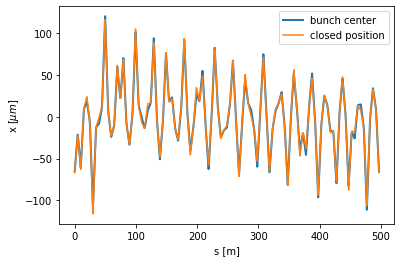

In [28]:
plt.plot(bo_et.spos,1e6*bunch_center[0,:], linewidth = 2, label="bunch center" )
plt.plot(bo_et.spos, 1e6*co[0,:],label = "closed position")
plt.ylabel("x [$\mu m$]")
plt.xlabel("s [m]")
plt.legend()

Changing reference frame to catch only betatron oscillations

Text(0.5, 0, 's [m]')

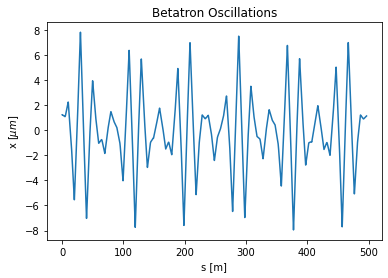

In [29]:
betatronx = bunch_center[0,:] - co[0,:]
plt.plot(bo_et.spos, betatronx*1e6)
plt.title("Betatron Oscillations")
plt.ylabel("x [$\mu m$]")
plt.xlabel("s [m]")

## BPM measure

In [30]:
famdata = pm.bo.families.get_family_data(lattice=bo)
bpm_idx = famdata["BPM"]['index']

Text(0.5, 0, 's [m]')

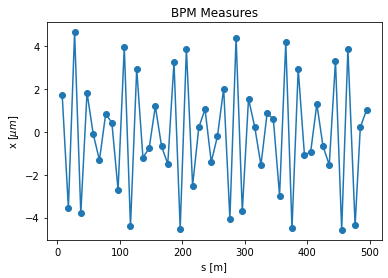

In [31]:
bpm_measure = betatronx[bpm_idx]
bpm_loc = bo_et.spos[bpm_idx]
plt.plot(bpm_loc,1e6*bpm_measure, linestyle="-", marker='o')
plt.title("BPM Measures")
plt.ylabel("x [$\mu m$]")
plt.xlabel("s [m]")

To apply Discrete Fourier Transform, we need bpm measures equally spaced.

In [32]:
delta_s = np.diff(bpm_loc[:,0])
delta_s

EdwardsTengArray([ 9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749,  9.935749,  9.935749,  9.935749,  9.935749,
                   9.935749, 11.532029,  8.339469,  9.935749])

Okey, its almost equally spaced... But I will consider that it is.  

## Discrete Fourier Transform and signal processing

In [33]:
from numpy.fft import fft, fftfreq
from scipy.signal import find_peaks

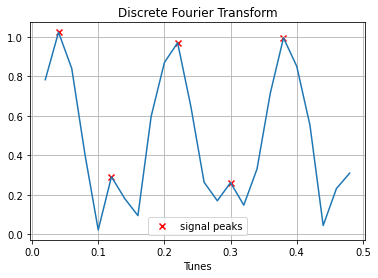

In [34]:
N = np.shape(bpm_measure)[0]

#Fourier Transform
yf = np.abs(fft(bpm_measure))
tunes = fftfreq(N)
mask = tunes>0
tunes, yf = tunes[mask], yf[mask]

yf_normalized = yf/(yf.max() - yf.min())

plt.plot(tunes, yf_normalized)
plt.title('Discrete Fourier Transform')
plt.xlabel('Tunes')
plt.grid(True)

# signal processing: finding proeminent peaks
peaks, properties = find_peaks(yf_normalized[:,0])
plt.scatter(tunes[peaks], yf_normalized[peaks], label="signal peaks", marker='x', c='r')
plt.legend()

In [35]:
print("Horizontal Tune:", eq_params.tune1) #Tune by Edwards Teng**

Horizontal Tune: 0.20436768515806503


In [36]:
tunes[peaks]

array([0.04, 0.12, 0.22, 0.3 , 0.38])

# Second Idea: Use a Single BPM 
This idea is based in the following equation

$x_j  = a \sqrt(\beta_0) cos(2 \pi \nu j + \phi_0)$

Which means that the betatron oscillation looked at a fixed azimuth behaves like a harmonic oscillation with an frequency $2\pi \nu$ in relation to the j-th passage.

## Tracking multiple turns of a particle at BPM location

Shifting the booster start point to the first BPM

In [37]:
bo2 = pa.lattice.shift(lattice=bo, start=bpm_idx[0][0])
print(bo2[0])

fam_name   : BPM 
pass_method: identity_pass 
hmin       : -0.018 m
hmax       : 0.018 m
vmin       : -0.018 m
vmax       : 0.018 m


Tracking using ring pass

In [38]:
turns = 100
part_rtrack, *_ = pa.tracking.ring_pass(accelerator=bo2,nr_turns=turns, particles = bunch,
                                        turn_by_turn=True, parallel=True)

Changing the reference to the closed orbit and measuring only the betatron oscillations

In [39]:
co2 = pa.tracking.find_orbit6(accelerator=bo2)
bunch_center2 = np.nanmean(part_rtrack, axis = 1)
betatronx_j = bunch_center2[0,:] - co2[0]

Text(0.5, 1.0, 'Betatron displacements at first BPM per turn ')

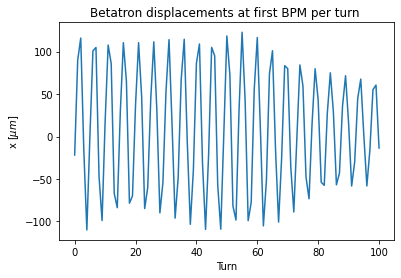

In [40]:
j_list = np.arange(turns+1)
plt.plot(j_list, 1e6*betatronx_j)
plt.xlabel('Turn')
plt.ylabel('x $[\mu m]$')
plt.title("Betatron displacements at first BPM per turn ")

## Fourier analysis again

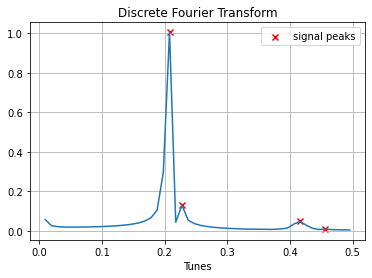

In [41]:
N=turns+1

#Fourier Transform
yf = np.abs(fft(betatronx_j))
tunes = fftfreq(N)
mask = tunes>0
tunes, yf = tunes[mask], yf[mask]

yf_normalized = yf/(yf.max() - yf.min())

plt.plot(tunes, yf_normalized)
plt.title('Discrete Fourier Transform')
plt.xlabel('Tunes')
plt.grid(True)

# signal processing: finding proeminent peaks
peaks, _ = find_peaks(yf_normalized)
plt.scatter(tunes[peaks], yf_normalized[peaks], label="signal peaks", marker='x', c='r')
plt.legend()

In [42]:
print(" Frequencies= {} \n Booster Horizontal Tune = {}".format(tuple(tunes[peaks]), eq_params.tune1))

 Frequencies= (0.2079207920792079, 0.22772277227722773, 0.4158415841584158, 0.45544554455445546) 
 Booster Horizontal Tune = 0.20436768515806503


I think that we need to improve the precision of this method because we will need to measure values of tune difference of order 0.01 or less. 

How to repeat this process for normal modes, that is, inputing $\beta_1$ and $\beta_2$ instead $\beta_x$ and $\beta_y$??

# Measuring tune with small coupling 

Introducing small coupling:

In [43]:
famdata = pm.bo.get_family_data(bo2)
qs_idx = famdata['QS']['index']
bo2[qs_idx[0][0]].KsL = -0.025  # Normalized skew quadrupole force
#bo2[qs_idx[0][0]].KsL = 0 
bo2_et,_ = pa.optics.calc_edwards_teng(bo2)
coupling_coef,_ = pa.optics.estimate_coupling_parameters(bo2_et) 
print("coupling = ",coupling_coef)

coupling =  0.06240764597343046


## Tracking particles with small coupling

In [44]:
from numpy.fft import fft, fftfreq
from scipy.signal import find_peaks

def tune_measure(betatronx_j, plot=False):
    
    N=np.size(betatronx_j)

    #Fourier Transform
    yf = np.abs(fft(betatronx_j))
    tunes = fftfreq(N)
    mask = tunes>0
    tunes, yf = tunes[mask], yf[mask]

    yf_normalized = yf/(yf.max() - yf.min())
    # signal processing: finding proeminent peaks
    peaks, _ = find_peaks(yf_normalized)
    
    if plot:
        plt.scatter(tunes[peaks], yf_normalized[peaks], label="signal peaks", marker='x', c='r')
        plt.plot(tunes, yf_normalized)
        plt.title('Discrete Fourier Transform')
        plt.xlabel('Tunes')
        plt.grid(True)
        plt.legend()
        #plt.show()
    
    return peaks, tunes, yf_normalized

In [45]:
turns = 100
part_ctrack, *_ = pa.tracking.ring_pass(accelerator=bo2, nr_turns=turns, particles = bunch,
                                        turn_by_turn=True, parallel=True)

coc = pa.tracking.find_orbit4(accelerator=bo2)
bunch_centerc = np.nanmean(part_ctrack, axis = 1)
betatronx_j = bunch_centerc[0,:] - coc[0]
betatrony_j = bunch_centerc[2,:] - coc[2]

j_list = np.arange(turns+1)

Text(0.5, 0, 'Tune')

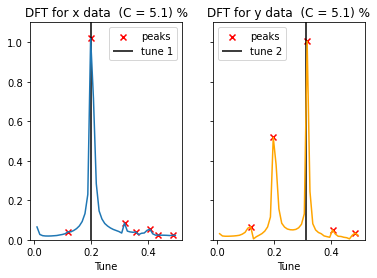

In [57]:
peaksx, tunesx, ampx = tune_measure(betatronx_j, plot=False)
peaksy, tunesy, ampy = tune_measure(betatrony_j, plot=False)
bo2_eqparams = pa.optics.EqParamsFromBeamEnvelope(bo2)
tune1, tune2 = bo2_eqparams.tune1, eq_params.tune2

fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].plot(tunesx, ampx)
ax[0].scatter(tunesx[peaksx], ampx[peaksx], label="peaks", marker='x', c='r')
ax[1].scatter(tunesx[peaksy], ampy[peaksy], label="peaks", marker='x', c='r')
ax[1].plot(tunesy, ampy, c='orange')
ax[0].set_title('DFT for x data  (C = {:.1f}) %'.format(coupling_coef*1e2) )
ax[1].set_title('DFT for y data  (C = {:.1f}) %'.format(coupling_coef*1e2) )
ax[0].vlines(tune1, ymin=0, ymax=1.1, color='k', label='tune 1')
ax[1].vlines(tune2, ymin=0, ymax=1.1, color='k', label="tune 2" )
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper left',)
ax[0].set_ylim(0,1.1)
ax[0].set_xlabel('Tune')
ax[1].set_xlabel('Tune')

## Further analysis 

Comparing the Tunes

In [47]:
print("Tune x = {} \n Tune y = {}".format(tunesx, tunesy))

Tune x = [0.00990099 0.01980198 0.02970297 0.03960396 0.04950495 0.05940594
 0.06930693 0.07920792 0.08910891 0.0990099  0.10891089 0.11881188
 0.12871287 0.13861386 0.14851485 0.15841584 0.16831683 0.17821782
 0.18811881 0.1980198  0.20792079 0.21782178 0.22772277 0.23762376
 0.24752475 0.25742574 0.26732673 0.27722772 0.28712871 0.2970297
 0.30693069 0.31683168 0.32673267 0.33663366 0.34653465 0.35643564
 0.36633663 0.37623762 0.38613861 0.3960396  0.40594059 0.41584158
 0.42574257 0.43564356 0.44554455 0.45544554 0.46534653 0.47524752
 0.48514851 0.4950495 ] 
 Tune y = [0.00990099 0.01980198 0.02970297 0.03960396 0.04950495 0.05940594
 0.06930693 0.07920792 0.08910891 0.0990099  0.10891089 0.11881188
 0.12871287 0.13861386 0.14851485 0.15841584 0.16831683 0.17821782
 0.18811881 0.1980198  0.20792079 0.21782178 0.22772277 0.23762376
 0.24752475 0.25742574 0.26732673 0.27722772 0.28712871 0.2970297
 0.30693069 0.31683168 0.32673267 0.33663366 0.34653465 0.35643564
 0.36633663 0.376237

In [48]:
bo2_eqparams = pa.optics.EqParamsFromBeamEnvelope(bo2)
bo2_eqparams.tune1, bo2_eqparams.tune2

(0.20020818798759776, 0.31864508972835637)

Beam dimension along the ring (at equilibrium)

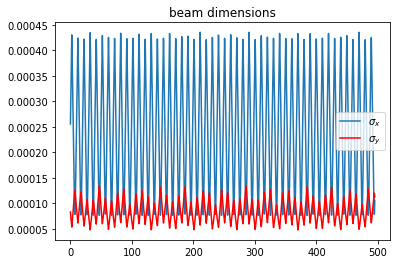

In [49]:
sigma_rx, sigma_ry = bo2_eqparams.sigma_rx, bo2_eqparams.sigma_ry
bo2spos = pa.lattice.find_spos(bo2)
plt.plot(bo2spos, sigma_rx[:-1], label='$\sigma_x$')
plt.plot(bo2spos, sigma_ry[:-1], c='r',label='$\sigma_y$')
plt.legend()
plt.title('beam dimensions')
plt.show()

Looking Betatron Oscillations with small coupling

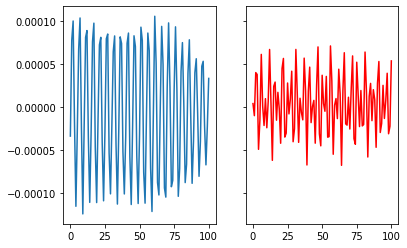

In [50]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True)
ax[0].plot(j_list, betatronx_j)
ax[1].plot(j_list, betatrony_j, c='r')

## Testing NAFF algorithm

In [51]:
naffx = pnf.naff(data=betatronx_j, turns=N, nterms=2, skipTurns=0, getFullSpectrum=False, window=1)
naffy = pnf.naff(data=betatrony_j, turns=N, nterms=2, skipTurns=0, getFullSpectrum=False, window=1)
#print("NaFF Tunes: ", tunes, "\n EqParams tunes: ", (eq_params.tune1, eq_params.tune2))

/home/jucelio/.local/lib/python3.6/site-packages/PyNAFF/PyNAFF.py:242: ComplexWarning: Casting complex values to real discards the imaginary part
  y = np.fft.rfft(data_for_fft.astype('float64'))


In [52]:
print(naffx[0][1], naffy[0][1])

0.20181976437171084 0.31779324817669413


# Third Idea: Mixed BPM algorithm 

At this section, i will implement the idea described at paper "Refined betatron tune measurements by mixing beam position data", by P. Zisopoulos and Y. Papaphilippou: 

https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.22.071002

Generating the machine

In [53]:
bo = pm.bo.create_accelerator(energy=3e9)
bo.cavity_on = True
bo.radiation_on = True
bo.vchamber_on = True

# Introducing coupling:
famdata = pm.bo.get_family_data(bo)
qs_idx = famdata['QS']['index']
#bo[qs_idx[0][0]].KsL = -0.03  # Normalized skew quadrupole force
bo[qs_idx[0][0]].KsL = -0.03
bo_et,_ = pa.optics.calc_edwards_teng(bo)
coupling_coef,_ = pa.optics.estimate_coupling_parameters(bo_et) 
print("coupling = ", coupling_coef)


coupling =  0.05082525819523674


Generating bunch

In [54]:
beam_envelope = pa.optics.calc_beamenvelope(bo)
start_envelope = beam_envelope[0]
bunch = pa.tracking.generate_bunch(n_part=1000, envelope=start_envelope)
co = pa.tracking.find_orbit6(accelerator=bo, indices='closed')
offset = np.array([[2e-6], [0], [1e-6], [0], [0], [0]])
bunch += co[:,[0]] + offset

Tracking the bunch at BPM positions for many turns 

In [55]:
bpm_idx = famdata['BPM']['index']

N_turns = 50
M = len(bpm_idx)

x_measures = np.zeros([N_turns, M])     # First idx = Turn of revolution
y_measures = np.zeros(x_measures.shape) # Second idx = measure at specific BPM 

for n in range(N_turns):
    part_out, *_ = pa.tracking.line_pass(accelerator=bo, particles=bunch, indices='closed', parallel=True)
    centroid = np.mean(part_out, axis=1)
    bpm_measures = centroid[:,bpm_idx].reshape(6,M)
    x_measures[n,:] = bpm_measures[0,:] # Selects measured x position to all BPM 
    y_measures[n,:] = bpm_measures[2,:] # Selects measured y position to all BPM 
    bunch = part_out[:,:,-1]

Comparing the teorical closed orbit with the mean of the beam

In [56]:
cox_tracking = np.mean(x_measures, axis=0)
plt.plot(spos[bpm_idx], cox_tracking, linestyle="-", marker='o', label = "Beam mean")
plt.plot(spos, co[0,:-1], label="Teorical closed orbit")
plt.legend()

NameError: name 'spos' is not defined

Getting only the betatron oscillations from the data

In [ ]:
beta_osc_x  = x_measures - np.mean(x_measures, axis=0)
beta_osc_y  = y_measures - np.mean(y_measures, axis=0) 

Now, let's flat this two matrices in one single 1-dimensional array, following the notation of the Zisopoulos   Papaphilippou paper:

In [ ]:
Ax = beta_osc_x.flatten()
Ay = beta_osc_y.flatten()

Final step: numerical analysis of numerical components 

In [ ]:
naffx = pnf.naff(Ax, turns=len(Ax), nterms=2, skipTurns=0, getFullSpectrum=False, window=1)
naffy = pnf.naff(Ay, turns=len(Ay), nterms=2, skipTurns=0, getFullSpectrum=False, window=1)

In [ ]:
tune1 = M*naffx[0][1]
tune2 = M*naffy[0][1]
print(tune1, tune2)

Comparing with tunes from Eq Parameters

In [ ]:
eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
print(eqparams.tune1, eqparams.tune2)

Comparing this result with the second idea boosted with measures from all bpms 

In [ ]:
tunesx = np.zeros(M)
tunesy = np.zeros(M)
for j in range(M):
    _, freqs, amps = tune_measure(beta_osc_x[:,j], False)
    tunesx[j] = freqs[np.where(amps == np.max(amps))]
    
    _, freqs, amps = tune_measure(beta_osc_y[:,j], False)
    tunesy[j] = freqs[np.where(amps == np.max(amps))]

In [ ]:
print(tunesx.mean(), tunesy.mean())